In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from mambapy.mamba import Mamba, MambaConfig
import gc
import wandb
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score


In [3]:
class MultiModalBalancedMultiLabelDataset(Dataset):
    """
    A balanced multi-label dataset that returns (X_spectra, X_gaia, y).
    It uses the same balancing strategy as `BalancedMultiLabelDataset`.
    """
    def __init__(self, X_spectra, X_gaia, y, limit_per_label=201):
        """
        Args:
            X_spectra (torch.Tensor): [num_samples, num_spectra_features]
            X_gaia (torch.Tensor): [num_samples, num_gaia_features]
            y (torch.Tensor): [num_samples, num_classes], multi-hot labels
            limit_per_label (int): limit or target number of samples per label
        """
        self.X_spectra = X_spectra
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.num_classes = y.shape[1]
        self.indices = self.balance_classes()
        
    def balance_classes(self):
        indices = []
        class_counts = torch.sum(self.y, axis=0)
        for cls in range(self.num_classes):
            cls_indices = np.where(self.y[:, cls] == 1)[0]
            if len(cls_indices) < self.limit_per_label:
                if len(cls_indices) == 0:
                    # No samples for this class
                    continue
                extra_indices = np.random.choice(
                    cls_indices, self.limit_per_label - len(cls_indices), replace=True
                )
                cls_indices = np.concatenate([cls_indices, extra_indices])
            elif len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        indices = np.unique(indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return (
            self.X_spectra[index],  # spectra features
            self.X_gaia[index],     # gaia features
            self.y[index],          # multi-hot labels
        )
def calculate_class_weights(y):
    if y.ndim > 1:  
        class_counts = np.sum(y, axis=0)  
    else:
        class_counts = np.bincount(y)

    total_samples = y.shape[0] if y.ndim > 1 else len(y)
    class_counts = np.where(class_counts == 0, 1, class_counts)  # Prevent division by zero
    class_weights = total_samples / (len(class_counts) * class_counts)
    
    return class_weights
def calculate_metrics(y_true, y_pred):
    metrics = {
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "micro_precision": precision_score(y_true, y_pred, average='micro', zero_division=1),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=1),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted', zero_division=1),
        "micro_recall": recall_score(y_true, y_pred, average='micro'),
        "macro_recall": recall_score(y_true, y_pred, average='macro'),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted'),
        "hamming_loss": hamming_loss(y_true, y_pred)
    }
    
    # Check if there are at least two classes present in y_true
    #if len(np.unique(y_true)) > 1:
        #metrics["roc_auc"] = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    #else:
       # metrics["roc_auc"] = None  # or you can set it to a default value or message
    
    return metrics


In [4]:
class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention block with a feed-forward sub-layer.
    """
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x_q, x_kv):
        """
        Args:
            x_q  : (batch_size, seq_len_q, d_model)
            x_kv : (batch_size, seq_len_kv, d_model)
        """
        # Cross-attention
        attn_output, _ = self.cross_attn(query=x_q, key=x_kv, value=x_kv)
        x = self.norm1(x_q + attn_output)

        # Feed forward
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


In [5]:
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        num_classes,
        input_dim_spectra,
        input_dim_gaia,
        n_layers=6,
        use_cross_attention=True,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        
        # --- MAMBA for spectra ---
        config_spectra = MambaConfig(
            d_model=d_model_spectra,
            d_state=64,
            d_conv=4,
            n_layers=n_layers,
        )
        self.mamba_spectra = Mamba(config_spectra)
        self.input_proj_spectra = nn.Linear(input_dim_spectra, d_model_spectra)

        # --- MAMBA for gaia ---
        config_gaia = MambaConfig(
            d_model=d_model_gaia,
            d_state=64,
            d_conv=4,
            n_layers=n_layers
        )
        self.mamba_gaia = Mamba(config_gaia)
        self.input_proj_gaia = nn.Linear(input_dim_gaia, d_model_gaia)

        # --- Cross Attention (Optional) ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # We'll do cross-attn in both directions or just one—here is an example with 2 blocks
            self.cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        # If you do late fusion by concatenation, the dimension is d_model_spectra + d_model_gaia
        # If you do average fusion, it is max(d_model_spectra, d_model_gaia) (or keep them separate).
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        """
        x_spectra : (batch_size, input_dim_spectra) or potentially (batch_size, seq_len_spectra, input_dim_spectra)
        x_gaia    : (batch_size, input_dim_gaia) or (batch_size, seq_len_gaia, input_dim_gaia)
        """
        # For MAMBA, we expect shape: (B, seq_len, d_model). 
        # If your input is just (B, d_in), we turn it into (B, 1, d_in).
        
        # --- Project to d_model and add sequence dimension (seq_len=1) ---
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, d_model_spectra)
        x_spectra = x_spectra.unsqueeze(1)             # (B, 1, d_model_spectra)

        x_gaia = self.input_proj_gaia(x_gaia)          # (B, d_model_gaia)
        x_gaia = x_gaia.unsqueeze(1)                   # (B, 1, d_model_gaia)

        # --- MAMBA encoding (each modality separately) ---
        x_spectra = self.mamba_spectra(x_spectra)  # (B, 1, d_model_spectra)
        x_gaia = self.mamba_gaia(x_gaia)          # (B, 1, d_model_gaia)

        # Optionally, use cross-attention to fuse the representations
        if self.use_cross_attention:
            # Cross-attention from spectra -> gaia
            x_spectra_fused = self.cross_attn_block_spectra(x_spectra, x_gaia)
            # Cross-attention from gaia -> spectra
            x_gaia_fused = self.cross_attn_block_gaia(x_gaia, x_spectra)
            
            # Update x_spectra and x_gaia
            x_spectra = x_spectra_fused
            x_gaia = x_gaia_fused
        
        # --- Pool across sequence dimension (since our seq_len=1, just squeeze) ---
        x_spectra = x_spectra.mean(dim=1)  # (B, d_model_spectra)
        x_gaia = x_gaia.mean(dim=1)        # (B, d_model_gaia)

        # --- Late Fusion by Concatenation ---
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)  # (B, d_model_spectra + d_model_gaia)

        # --- Final classification ---
        logits = self.classifier(x_fused)  # (B, num_classes)
        return logits


In [6]:
def train_model_fusion(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=100,
    lr=1e-4,
    max_patience=20,
    device='cuda'
):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=int(max_patience / 5)
    )

    # We assume the datasets are MultiModalBalancedMultiLabelDataset
    # that returns (X_spectra, X_gaia, y).
    # You can keep the class weighting logic as in train_model_mamba.
    all_labels = []
    for _, _, y_batch in train_loader:
        all_labels.extend(y_batch.cpu().numpy())
    
    class_weights = calculate_class_weights(np.array(all_labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    
    best_val_loss = float('inf')
    patience = max_patience

    for epoch in range(num_epochs):
        # Resample training data
        train_loader.dataset.re_sample()

        # Recompute class weights if needed
        all_labels = []
        for _, _, y_batch in train_loader:
            all_labels.extend(y_batch.cpu().numpy())
        class_weights = calculate_class_weights(np.array(all_labels))
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

        # --- Training ---
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for X_spc, X_ga, y_batch in train_loader:
            X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_spc, X_ga)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_spc.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct = (predicted == y_batch).float()
            train_acc += correct.mean(dim=1).mean().item()

        # --- Validation ---
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for X_spc, X_ga, y_batch in val_loader:
                X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
                outputs = model(X_spc, X_ga)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_spc.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct = (predicted == y_batch).float()
                val_acc += correct.mean(dim=1).mean().item()

        # --- Test metrics (optional or do after training) ---
        test_loss, test_acc = 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_spc, X_ga, y_batch in test_loader:
                X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
                outputs = model(X_spc, X_ga)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_spc.size(0)
                
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct = (predicted == y_batch).float()
                test_acc += correct.mean(dim=1).mean().item()

                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Compute multi-label metrics as before
        all_metrics = calculate_metrics(np.array(y_true), np.array(y_pred))

        # Logging example
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_acc": train_acc / len(train_loader),
            "val_acc": val_acc / len(val_loader),
            "test_loss": test_loss / len(test_loader.dataset),
            "test_acc": test_acc / len(test_loader),
            **all_metrics
        })

        # Scheduler
        scheduler.step(val_loss / len(val_loader.dataset))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
            best_model = model.state_dict()
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model


In [6]:
batch_size = 128
batch_limit = int(batch_size / 2.5)

# Load datasets
#X_train_full = pd.read_pickle("Pickles/train_data_transformed2.pkl")
#X_test_full = pd.read_pickle("Pickles/test_data_transformed.pkl")
# classes = pd.read_pickle("Pickles/Updated_list_of_Classes.pkl")
import pickle
# Open them in a cross-platform way
with open("Pickles/Updated_List_of_Classes_ubuntu.pkl", "rb") as f:
    classes = pickle.load(f)  # This reads the actual data
with open("Pickles/train_data_transformed_ubuntu.pkl", "rb") as f:
    X_train_full = pickle.load(f)
with open("Pickles/test_data_transformed_ubuntu.pkl", "rb") as f:
    X_test_full = pickle.load(f)




# Extract labels
y_train_full = X_train_full[classes]
y_test = X_test_full[classes]

# Drop labels from both datasets
X_train_full.drop(classes, axis=1, inplace=True)
X_test_full.drop(classes, axis=1, inplace=True)


# Columns for spectral data (assuming all remaining columns after removing Gaia are spectra)
gaia_columns = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", 
                "pmra_error", "pmdec_error", "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", 
                "phot_bp_mean_flux", "phot_rp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", 
                "flagnoflux"]

# Spectra data (everything that is not Gaia-related) and the column 'otype'
X_train_spectra = X_train_full.drop(columns={"otype", "obsid", *gaia_columns})
X_test_spectra = X_test_full.drop(columns={"otype", "obsid", *gaia_columns})

# Gaia data (only the selected columns)
X_train_gaia = X_train_full[gaia_columns]
X_test_gaia = X_test_full[gaia_columns]

# Count nans and infs in x_train_gaia
print(X_train_gaia.isnull().sum())
print(X_train_gaia.isin([np.inf, -np.inf]).sum())


# Free up memory
del X_train_full, X_test_full
gc.collect()



# Split training set into training and validation
X_train_spectra, X_val_spectra, X_train_gaia, X_val_gaia, y_train, y_val = train_test_split(
    X_train_spectra, X_train_gaia, y_train_full, test_size=0.2, random_state=42
)

# Free memory
del y_train_full
gc.collect()



# Convert spectra and Gaia data into PyTorch tensors
X_train_spectra = torch.tensor(X_train_spectra.values, dtype=torch.float32)
X_val_spectra = torch.tensor(X_val_spectra.values, dtype=torch.float32)
X_test_spectra = torch.tensor(X_test_spectra.values, dtype=torch.float32)



X_train_gaia = torch.tensor(X_train_gaia.values, dtype=torch.float32)
X_val_gaia = torch.tensor(X_val_gaia.values, dtype=torch.float32)
X_test_gaia = torch.tensor(X_test_gaia.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Print dataset shapes
print(f"X_train_spectra shape: {X_train_spectra.shape}")
print(f"X_val_spectra shape: {X_val_spectra.shape}")
print(f"X_test_spectra shape: {X_test_spectra.shape}")

print(f"X_train_gaia shape: {X_train_gaia.shape}")
print(f"X_val_gaia shape: {X_val_gaia.shape}")
print(f"X_test_gaia shape: {X_test_gaia.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


train_dataset = MultiModalBalancedMultiLabelDataset(X_train_spectra, X_train_gaia, y_train, limit_per_label=batch_limit)
val_dataset = MultiModalBalancedMultiLabelDataset(X_val_spectra, X_val_gaia, y_val, limit_per_label=batch_limit)
test_dataset = MultiModalBalancedMultiLabelDataset(X_test_spectra, X_test_gaia, y_test, limit_per_label=batch_limit)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print the number of samples in each dataset
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


parallax                   0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax_error             0
pmra                       0
pmdec                      0
pmra_error                 0
pmdec_error                0
phot_g_mean_flux           0
flagnopllx                 0
phot_g_mean_flux_error     0
phot_bp_mean_flux          0
phot_rp_mean_flux          0
phot_bp_mean_flux_error    0
phot_rp_mean_flux_error    0
flagnoflux                 0
dtype: int64
parallax                   0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax_error             0
pmra                       0
pmdec                      0
pmra_error                 0
pmdec_error                0
phot_g_mean_flux           0
flagnopllx                 0
phot_g_mean_flux_error     0
phot_bp_mean_flux          0
phot_rp_mean_flux          0
phot_bp_mean_flux_error    0
p

In [7]:
if __name__ == "__main__":
    # Suppose you have these prepared:
    #   X_train_spectra, X_val_spectra, X_test_spectra
    #   X_train_gaia,    X_val_gaia,    X_test_gaia
    #   y_train,         y_val,         y_test
    #
    # All as torch.FloatTensors, shaped [N, features], for instance.
    #
    # Then you create your multi-modal dataset:

    train_dataset = MultiModalBalancedMultiLabelDataset(
        X_train_spectra, X_train_gaia, y_train, limit_per_label=batch_limit
    )
    val_dataset = MultiModalBalancedMultiLabelDataset(
        X_val_spectra, X_val_gaia, y_val, limit_per_label=batch_limit
    )
    test_dataset = MultiModalBalancedMultiLabelDataset(
        X_test_spectra, X_test_gaia, y_test, limit_per_label=batch_limit
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print the number of samples in each dataset
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")


Train samples: 1859
Val samples: 1517
Test samples: 1582


In [8]:
def check_nan_inf(tensor, name):
    if torch.isnan(tensor).any():
        print(f"⚠️ NaNs detected in {name}")
    if torch.isinf(tensor).any():
        print(f"⚠️ Infs detected in {name}")

check_nan_inf(X_train_spectra, "X_train_spectra")
check_nan_inf(X_train_gaia, "X_train_gaia")
check_nan_inf(y_train, "y_train")

check_nan_inf(X_val_spectra, "X_val_spectra")
check_nan_inf(X_val_gaia, "X_val_gaia")
check_nan_inf(y_val, "y_val")


In [9]:
# Count nans and infs in x_train_gaia
print("Number of NaNs in X_train_gaia:", torch.isnan(X_train_gaia).sum().item())
print("Number of Infs in X_train_gaia:", torch.isinf(X_train_gaia).sum().item())

# Print the samples with NaNs in X_train_gaia
nan_indices = torch.isnan(X_train_gaia).any(dim=1)
print("Indices of samples with NaNs in X_train_gaia:", torch.where(nan_indices)[0])
print("all values of sample with nan in  X_train_gaia:", X_train_gaia[torch.where(nan_indices)[0]])


Number of NaNs in X_train_gaia: 0
Number of Infs in X_train_gaia: 0
Indices of samples with NaNs in X_train_gaia: tensor([], dtype=torch.int64)
all values of sample with nan in  X_train_gaia: tensor([], size=(0, 18))


In [10]:
import wandb
wandb.login(key="8a64e112210e005fa7744360c3561ebbbf66c001")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/joao/.netrc
wandb: Currently logged in as: joaocsgalmeida (joaocsgalmeida-university-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
if __name__ == "__main__":
    # Example config
    d_model_spectra = 2048
    d_model_gaia = 2048
    num_classes = 55
    input_dim_spectra = 3647
    input_dim_gaia = 18
    n_layers = 12
    lr = 2.5e-5
    patience = 600
    num_epochs = 8000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device:", device)

    # Initialize WandB
    wandb.init(project="ALLSTARS_multimodal_fusion_mamba")
    
    config = {
        "num_classes": num_classes,
        "d_model_spectra": d_model_spectra,
        "d_model_gaia": d_model_gaia,
        "input_dim_spectra": input_dim_spectra,
        "input_dim_gaia": input_dim_gaia,
        "n_layers": n_layers,
        "lr": lr,
        "patience": patience,
        "num_epochs": num_epochs
    }
    wandb.config.update(config)

    # Instantiate the fusion model
    # Try use_cross_attention=False for late-fusion, True for cross-attention
    model_fusion = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=n_layers,
        use_cross_attention=True,  # set to False to compare with late fusion
        n_cross_attn_heads=8
    )
    model_fusion.to(device)

    # Print size of model in GB
    print(f"Model size: {sum(p.numel() for p in model_fusion.parameters()) / 1e9:.2f} GB")
    param_size = 0
    for param in model_fusion.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model_fusion.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))
    # Compute parameter size
    param_size = sum(p.nelement() * p.element_size() for p in model_fusion.parameters())

    # Compute buffer size
    buffer_size = sum(b.nelement() * b.element_size() for b in model_fusion.buffers())

    # Total size in MB
    total_size_mb = (param_size + buffer_size) / (1024 ** 2)
    print(f"Model size: {total_size_mb:.3f} MB")

    print(model_fusion)
    # print number of parameters per layer
    for name, param in model_fusion.named_parameters():
        print(name, param.numel())
    print("Total number of parameters:", sum(p.numel() for p in model_fusion.parameters() if p.requires_grad))

    # Train the fusion model
    trained_fusion_model = train_model_fusion(
        model=model_fusion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        lr=lr,
        max_patience=patience,
        device=device
    )

    wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Device: cuda


Model size: 0.76 GB
model size: 2888.555MB
Model size: 2888.555 MB
StarClassifierFusion(
  (mamba_spectra): Mamba(
    (layers): ModuleList(
      (0-11): 12 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (conv1d): Conv1d(4096, 4096, kernel_size=(4,), stride=(1,), padding=(3,), groups=4096)
          (x_proj): Linear(in_features=4096, out_features=256, bias=False)
          (dt_proj): Linear(in_features=128, out_features=4096, bias=True)
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (input_proj_spectra): Linear(in_features=3647, out_features=2048, bias=True)
  (mamba_gaia): Mamba(
    (layers): ModuleList(
      (0-11): 12 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (conv1d): Conv1d(4096, 4096, kernel_size=(4,), stride=(1,), pa

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
hamming_loss,█▇▆▄▄▃▃▃▃▃▃▃▂▂▃▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
macro_f1,▁▄▆▆▇▇▇▇███████████████████████████▇██▇█
macro_precision,█▁▃▂▃▂▄▂▂▃▃▃▄▄▄▄▃▄▄▅▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄
macro_recall,▁▁▅▇▇▇█▇▇███████████████████████████████
micro_f1,▁▁▇▇▇███████████████████████████████████
micro_precision,▃▅▆▇▅█▆▅▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁
micro_recall,▁▃▃▄▄▄▆▅▅▅▆▇▇▇▆█▇▇▇▇▇▇█▇▇▇██████████████
test_acc,▁▁▂▂▂▅▄▅▅▆▅▄▅▆▆▇██▇▇▇█▇█▇█▇█▇█▇▇▇▇▇▆▇▇▇▇
test_loss,▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
train_acc,▁▃▄▄▅▅▅▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████


In [12]:
breakestnyrn

NameError: name 'breakestnyrn' is not defined

In [ ]:
if __name__ == "__main__":
    # Example config
    d_model_spectra = 1024
    d_model_gaia = 1024
    num_classes = 55
    input_dim_spectra = 3647
    input_dim_gaia = 18
    n_layers = 12
    lr = 2.5e-5
    patience = 600
    num_epochs = 8000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize WandB
    wandb.init(project="ALLSTARS_multimodal_fusion_mamba", entity="joaoc-university-of-southampton")
    
    config = {
        "num_classes": num_classes,
        "d_model_spectra": d_model_spectra,
        "d_model_gaia": d_model_gaia,
        "input_dim_spectra": input_dim_spectra,
        "input_dim_gaia": input_dim_gaia,
        "n_layers": n_layers,
        "lr": lr,
        "patience": patience,
        "num_epochs": num_epochs
    }
    wandb.config.update(config)

    # Instantiate the fusion model
    # Try use_cross_attention=False for late-fusion, True for cross-attention
    model_fusion = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=n_layers,
        use_cross_attention=True,  # set to False to compare with late fusion
        n_cross_attn_heads=8
    )
    model_fusion.to(device)

    # Print size of model in GB
    print(f"Model size: {sum(p.numel() for p in model_fusion.parameters()) / 1e9:.2f} GB")
    param_size = 0
    for param in model_fusion.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model_fusion.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))
    # Compute parameter size
    param_size = sum(p.nelement() * p.element_size() for p in model_fusion.parameters())

    # Compute buffer size
    buffer_size = sum(b.nelement() * b.element_size() for b in model_fusion.buffers())

    # Total size in MB
    total_size_mb = (param_size + buffer_size) / (1024 ** 2)
    print(f"Model size: {total_size_mb:.3f} MB")

    print(model_fusion)
    # print number of parameters per layer
    for name, param in model_fusion.named_parameters():
        print(name, param.numel())
    print("Total number of parameters:", sum(p.numel() for p in model_fusion.parameters() if p.requires_grad))

    # Train the fusion model
    trained_fusion_model = train_model_fusion(
        model=model_fusion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        lr=lr,
        max_patience=patience,
        device=device
    )

    wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joaoc (joaoc-university-of-southampton). Use `wandb login --relogin` to force relogin


Model size: 0.20 GB
model size: 748.278MB
Model size: 748.278 MB
StarClassifierFusion(
  (mamba_spectra): Mamba(
    (layers): ModuleList(
      (0-11): 12 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (x_proj): Linear(in_features=2048, out_features=192, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (input_proj_spectra): Linear(in_features=3647, out_features=1024, bias=True)
  (mamba_gaia): Mamba(
    (layers): ModuleList(
      (0-11): 12 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), paddi

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
hamming_loss,██▆▄▄▃▃▄▃▁▂▂▂▁▂▁▂▂▂▃▂▂▂▂▃▁▂▂▂▂▂▃▂▃▃▃▃▃▃▃
macro_f1,▁▃▁▅▅▆▅▆▅▃▄▄█▇▇▇▆▇▇▇█▆▇▇▇▆▇▇▇▆▇▇▇▆▇▆▇▆▇▆
macro_precision,█▂▁▂▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃
macro_recall,▁▁▂▆▆▇▇▇▇▇██▇▇██████████████████████████
micro_f1,▃▂▂▂▄▁▄▁▄▅▆▄▅▅▅▆▄▄▅▇▆▆▅▆▇▅█▇▆▆▅▆▆▆▆▆▇▇▇▆
micro_precision,█▁▁▄▅▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
micro_recall,▁▃▅▅▆▇▆▇▇▇▇▇▇▇█████▇████████████████████
test_acc,▁▄▆▆▇▇█▇█████████████████████████▇▇████▇
test_loss,▇▂▁▁▁▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████████
train_acc,▁▁▁▄▆▆▆▆▆▇▇▇▇▇▇█████████████████████████


In [13]:
# Save the model
torch.save(trained_fusion_model.state_dict(), "model_fusion_mamba_v3.pth")

In [8]:
def process_star_data_fusion(
    model_path, 
    data_path, 
    classes_path, 
    d_model_spectra=2048, 
    d_model_gaia=2048, 
    num_classes=55, 
    input_dim_spectra=3647, 
    input_dim_gaia=18, 
    depth=12, 
    sigmoid_constant=0.5,
    class_to_plot="AllStars***lamost"
):
    """Processes star data using the fused StarClassifierFusion model."""

    # Load the data
    X = pd.read_pickle(data_path)
    classes = pd.read_pickle(classes_path)

    # Load the trained fusion model
    model = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=depth,
        use_cross_attention=True,  # Change to False for late fusion
        n_cross_attn_heads=8
    )

    # Load the state dictionary
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # Get multi-hot encoded labels
    y = X[classes]

    # Define Gaia columns
    gaia_columns = [
        "parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec",
        "pmra_error", "pmdec_error", "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error",
        "phot_bp_mean_flux", "phot_rp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux_error",
        "flagnoflux"
    ]

    # Separate Gaia and Spectra features
    X_spectra = X.drop(columns={"otype", "obsid", *gaia_columns})
    X_gaia = X[gaia_columns]

    print(f"X_spectra shape: {X_spectra.shape}")
    print(f"X_gaia shape: {X_gaia.shape}")
    print(f"y shape: {y.shape}")

    if class_to_plot != "AllStars***lamost":
        # Filter for a specific class
        X_spectra = X_spectra[y[class_to_plot] == 1]
        X_gaia = X_gaia[y[class_to_plot] == 1]
        y = y[y[class_to_plot] == 1]

        print(f"X_spectra shape after filtering for {class_to_plot}: {X_spectra.shape}")
        print(f"X_gaia shape after filtering for {class_to_plot}: {X_gaia.shape}")
        print(f"y shape after filtering for {class_to_plot}: {y.shape}")

    # Drop label columns from spectra
    X_spectra.drop(classes, axis=1, inplace=True)

    # Convert to tensors
    X_spectra = torch.tensor(X_spectra.values, dtype=torch.float32)
    X_gaia = torch.tensor(X_gaia.values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)

    # Create DataLoader
    class MultiModalDataset(Dataset):
        def __init__(self, X_spectra, X_gaia, y):
            self.X_spectra = X_spectra
            self.X_gaia = X_gaia
            self.y = y

        def __len__(self):
            return len(self.X_spectra)

        def __getitem__(self, idx):
            return self.X_spectra[idx], self.X_gaia[idx], self.y[idx]

    dataset = MultiModalDataset(X_spectra, X_gaia, y)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

    # Move model to device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()

    all_predicted = []
    all_y = []

    with torch.no_grad():
        for X_spc, X_ga, y_batch in loader:
            # Move data to device
            X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_spc, X_ga)
            predicted = (torch.sigmoid(outputs) > sigmoid_constant).float()

            # Store predictions and labels
            all_predicted.append(predicted.cpu().numpy())
            all_y.append(y_batch.cpu().numpy())

            # Free GPU memory
            torch.cuda.empty_cache()

    # Concatenate all predictions and labels
    y_cpu = np.concatenate(all_y, axis=0)
    predicted_cpu = np.concatenate(all_predicted, axis=0)

    return y_cpu, predicted_cpu

In [ ]:
# Release gpu memory
torch.cuda.empty_cache()


In [12]:
# Example usage
model_path = "model_fusion_mamba_v3.pth"
data_path = "Pickles/test_data_transformed_ubuntu.pkl"
classes_path = "Pickles/Updated_List_of_Classes_ubuntu.pkl"

# Normal Mode
y_cpu, predicted_cpu = process_star_data_fusion(model_path, data_path, classes_path, sigmoid_constant=0.5)

# Save the predictions
np.save("Results/mamba_fused_v3_y_cpu.npy", y_cpu)
np.save("Results/mamba_fused_v3_predicted_cpu.npy", predicted_cpu)

# Precission Mode
y_cpu, predicted_cpu = process_star_data_fusion(model_path, data_path, classes_path, sigmoid_constant=0.1)

# Save the predictions
np.save("Results/mamba_fused_v3_y_cpu_01.npy", y_cpu)
np.save("Results/mamba_fused_v3_predicted_cpu_01.npy", predicted_cpu)

# Recall Mode
y_cpu, predicted_cpu = process_star_data_fusion(model_path, data_path, classes_path, sigmoid_constant=0.9)

# Save the predictions
np.save("Results/mamba_fused_v3_y_cpu_09.npy", y_cpu)
np.save("Results/mamba_fused_v3_predicted_cpu_09.npy", predicted_cpu)

X_spectra shape: (27237, 3702)
X_gaia shape: (27237, 18)
y shape: (27237, 55)
X_spectra shape: (27237, 3702)
X_gaia shape: (27237, 18)
y shape: (27237, 55)
X_spectra shape: (27237, 3702)
X_gaia shape: (27237, 18)
y shape: (27237, 55)


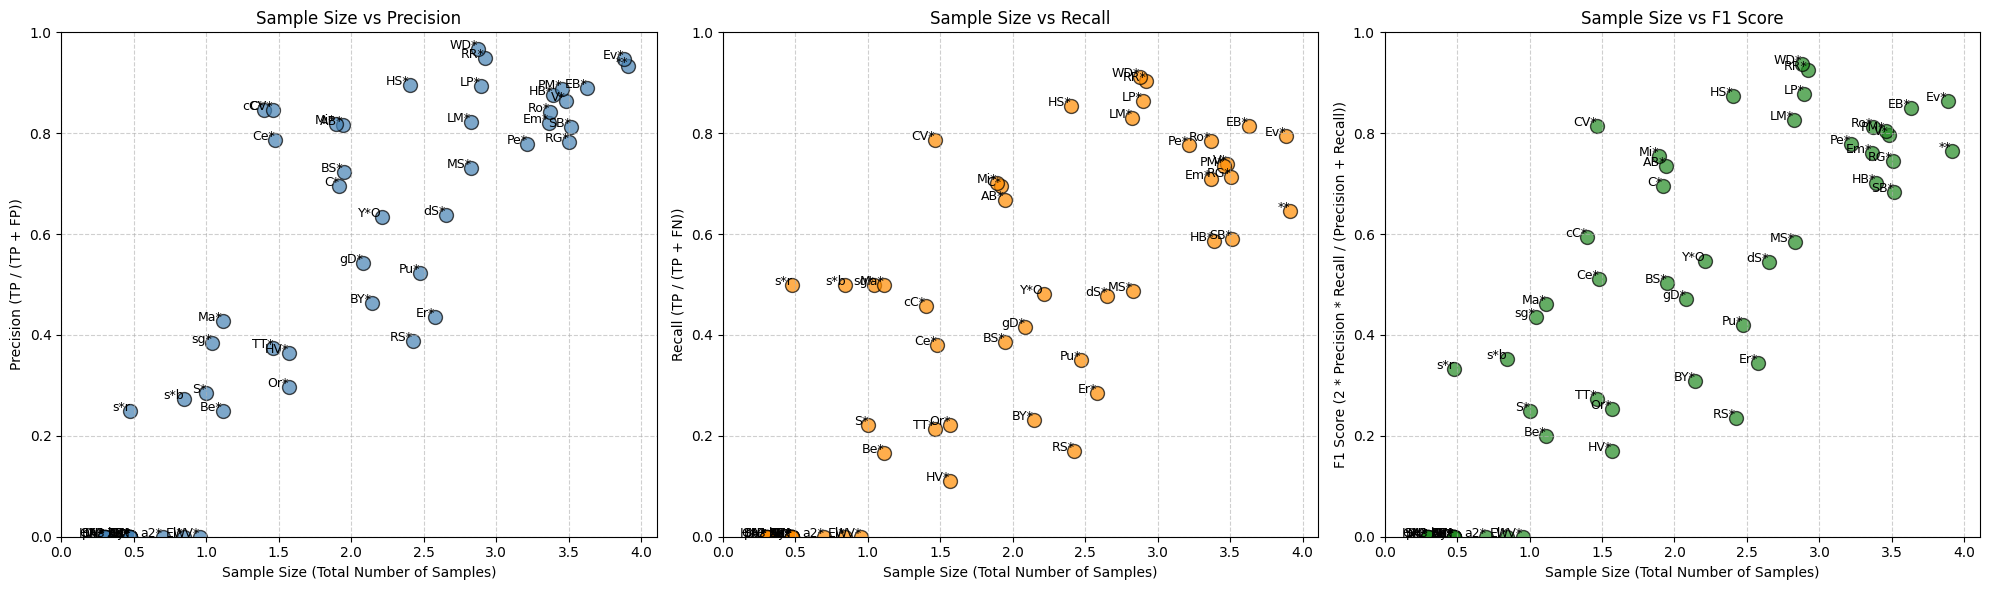

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score

def calculate_precision_per_class(true_labels, predicted_labels):
    """
    Calculates the precision for each class.
    """
    precisions = []
    for i in range(true_labels.shape[1]):
        true_positives = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_positives = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))

        if true_positives + false_positives == 0:
            precision = 0  # Avoid division by zero
        else:
            precision = true_positives / (true_positives + false_positives)

        precisions.append(precision)
    return precisions

def calculate_f1_score_per_class(true_labels, predicted_labels):
    """Calculate the F1 score for each class."""
    f1_scores = []
    for i in range(true_labels.shape[1]):
        f1 = f1_score(true_labels[:, i], predicted_labels[:, i])
        f1_scores.append(f1)
    return f1_scores

def calculate_recall_per_class(true_labels, predicted_labels):
    """Calculate the Recall score for each class."""
    recalls = []
    for i in range(true_labels.shape[1]):
        recall = recall_score(true_labels[:, i], predicted_labels[:, i])
        recalls.append(recall)
    return recalls

def calculate_sample_size_per_class(true_labels):
    """Calculates the sample size for each class."""
    return np.sum(true_labels, axis=0)

def plot_metrics_per_class(true_labels, predicted_labels, class_names, log_scale=False):
    """
    Plots precision, recall, and F1 score against sample size for each class.
    """
    sample_sizes = calculate_sample_size_per_class(true_labels)
    precisions = calculate_precision_per_class(true_labels, predicted_labels)
    f1_scores = calculate_f1_score_per_class(true_labels, predicted_labels)
    recalls = calculate_recall_per_class(true_labels, predicted_labels)

    if log_scale:
        sample_sizes = np.log10(sample_sizes + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Precision plot
    axes[0].scatter(sample_sizes, precisions, color='steelblue', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[0].text(sample_sizes[i], precisions[i], class_name, fontsize=9, ha='right')

    axes[0].set_xlabel('Sample Size (Total Number of Samples)')
    axes[0].set_ylabel('Precision (TP / (TP + FP))')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[0].set_ylim(-0.0, 1.0)
    axes[0].set_title("Sample Size vs Precision")

    # Recall plot
    axes[1].scatter(sample_sizes, recalls, color='darkorange', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[1].text(sample_sizes[i], recalls[i], class_name, fontsize=9, ha='right')

    axes[1].set_xlabel('Sample Size (Total Number of Samples)')
    axes[1].set_ylabel('Recall (TP / (TP + FN))')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[1].set_ylim(-0.0, 1.0)
    axes[1].set_title("Sample Size vs Recall")

    # F1 Score plot
    axes[2].scatter(sample_sizes, f1_scores, color='forestgreen', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[2].text(sample_sizes[i], f1_scores[i], class_name, fontsize=9, ha='right')

    axes[2].set_xlabel('Sample Size (Total Number of Samples)')
    axes[2].set_ylabel('F1 Score (2 * Precision * Recall / (Precision + Recall))')
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[2].set_ylim(-0.0, 1.0)
    axes[2].set_title("Sample Size vs F1 Score")

    plt.tight_layout()
    plt.show()

# Load saved predictions
y_cpu = np.load("Results/mamba_fused_v3_y_cpu.npy")
predicted_cpu = np.load("Results/mamba_fused_v3_predicted_cpu.npy")

# Load class names
import pandas as pd
classes = pd.read_pickle("Pickles/Updated_List_of_Classes_ubuntu.pkl")

# Plot the results with log scale sample size
plot_metrics_per_class(y_cpu, predicted_cpu, classes, log_scale=True)


/tmp/ipykernel_37311/1140671330.py:71: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim(0, np.max(sample_sizes) * 1.05)
/tmp/ipykernel_37311/1140671330.py:89: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim(0, np.max(sample_sizes) * 1.05)
/tmp/ipykernel_37311/1140671330.py:107: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[2].set_xlim(0, np.max(sample_sizes) * 1.05)


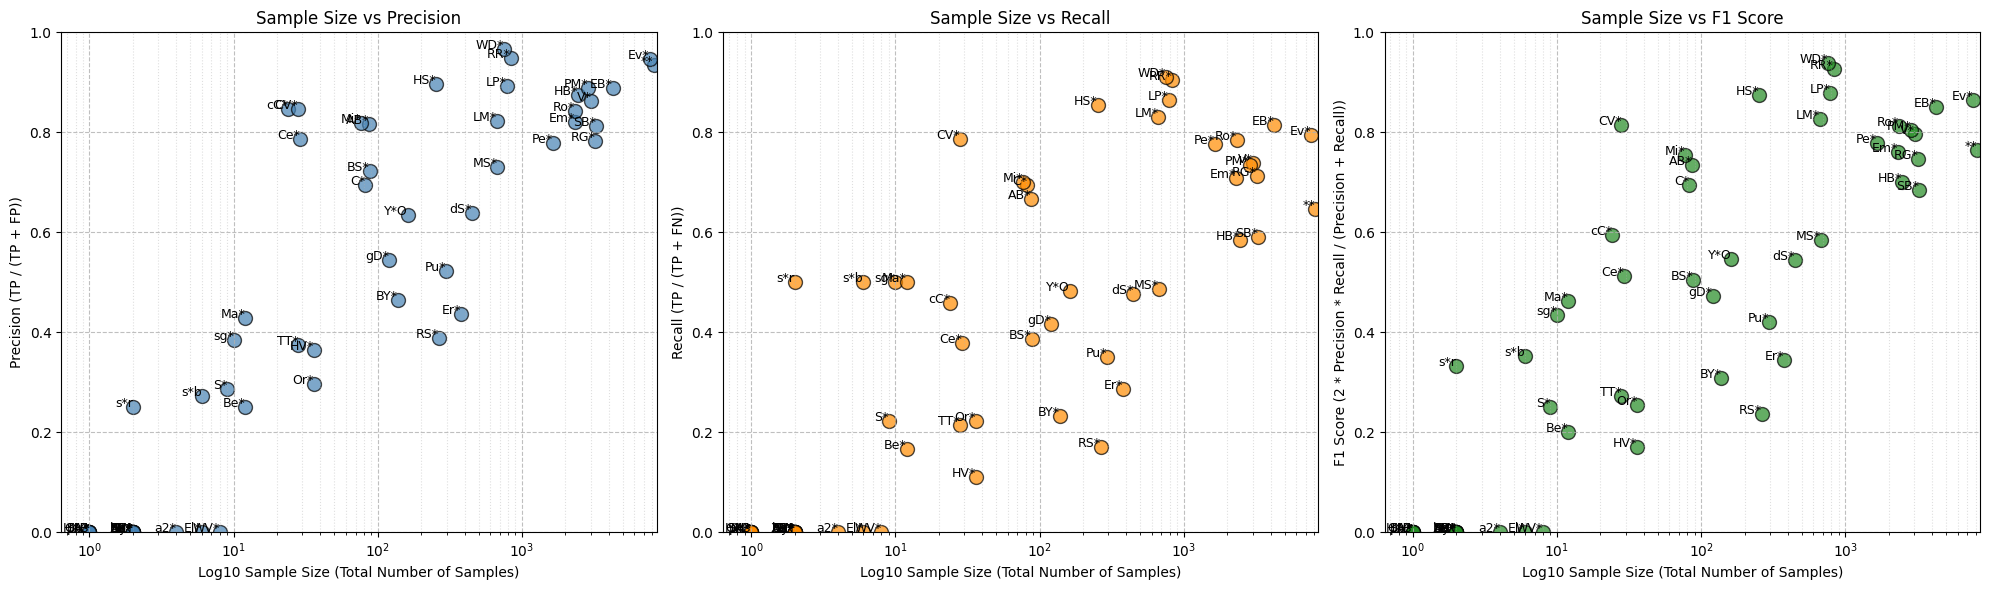

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score

def calculate_precision_per_class(true_labels, predicted_labels):
    """
    Calculates the precision for each class.
    """
    precisions = []
    for i in range(true_labels.shape[1]):
        true_positives = np.sum((true_labels[:, i] == 1) & (predicted_labels[:, i] == 1))
        false_positives = np.sum((true_labels[:, i] == 0) & (predicted_labels[:, i] == 1))

        if true_positives + false_positives == 0:
            precision = 0  # Avoid division by zero
        else:
            precision = true_positives / (true_positives + false_positives)

        precisions.append(precision)
    return precisions

def calculate_f1_score_per_class(true_labels, predicted_labels):
    """Calculate the F1 score for each class."""
    f1_scores = []
    for i in range(true_labels.shape[1]):
        f1 = f1_score(true_labels[:, i], predicted_labels[:, i])
        f1_scores.append(f1)
    return f1_scores

def calculate_recall_per_class(true_labels, predicted_labels):
    """Calculate the Recall score for each class."""
    recalls = []
    for i in range(true_labels.shape[1]):
        recall = recall_score(true_labels[:, i], predicted_labels[:, i])
        recalls.append(recall)
    return recalls

def calculate_sample_size_per_class(true_labels):
    """Calculates the sample size for each class."""
    return np.sum(true_labels, axis=0)

def plot_metrics_per_class(true_labels, predicted_labels, class_names, log_scale=False):
    """
    Plots precision, recall, and F1 score against sample size for each class.
    """
    sample_sizes = calculate_sample_size_per_class(true_labels)
    precisions = calculate_precision_per_class(true_labels, predicted_labels)
    f1_scores = calculate_f1_score_per_class(true_labels, predicted_labels)
    recalls = calculate_recall_per_class(true_labels, predicted_labels)

    #if log_scale:
        #sample_sizes = np.log10(sample_sizes + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Precision plot
    axes[0].scatter(sample_sizes, precisions, color='steelblue', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[0].text(sample_sizes[i], precisions[i], class_name, fontsize=9, ha='right')
    
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[0].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[0].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[0].set_xlabel('Sample Size (Total Number of Samples)')
        axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[0].set_ylabel('Precision (TP / (TP + FP))')
    axes[0].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[0].set_ylim(-0.0, 1.0)
    axes[0].set_title("Sample Size vs Precision")

    # Recall plot
    axes[1].scatter(sample_sizes, recalls, color='darkorange', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[1].text(sample_sizes[i], recalls[i], class_name, fontsize=9, ha='right')

    if log_scale:
        axes[1].set_xscale('log')
        axes[1].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[1].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[1].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[1].set_xlabel('Sample Size (Total Number of Samples)')
        axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].set_ylabel('Recall (TP / (TP + FN))')
    axes[1].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[1].set_ylim(-0.0, 1.0)
    axes[1].set_title("Sample Size vs Recall")

    # F1 Score plot
    axes[2].scatter(sample_sizes, f1_scores, color='forestgreen', s=100, edgecolors='k', alpha=0.7)
    for i, class_name in enumerate(class_names):
        axes[2].text(sample_sizes[i], f1_scores[i], class_name, fontsize=9, ha='right')

    if log_scale:
        axes[2].set_xscale('log')
        axes[2].set_xlabel('Log10 Sample Size (Total Number of Samples)')
        axes[2].grid(True, which='major', linestyle='--', alpha=0.8)
        axes[2].grid(True, which='minor', linestyle=':', alpha=0.4)
    else:
        axes[2].set_xlabel('Sample Size (Total Number of Samples)')
        axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].set_ylabel('F1 Score (2 * Precision * Recall / (Precision + Recall))')
    axes[2].set_xlim(0, np.max(sample_sizes) * 1.05)
    axes[2].set_ylim(-0.0, 1.0)
    axes[2].set_title("Sample Size vs F1 Score")

    plt.tight_layout()
    plt.show()

# Load saved predictions
y_cpu = np.load("Results/mamba_fused_v3_y_cpu.npy")
predicted_cpu = np.load("Results/mamba_fused_v3_predicted_cpu.npy")

# Load class names
import pandas as pd
classes = pd.read_pickle("Pickles/Updated_List_of_Classes_ubuntu.pkl")

# Plot the results with log scale sample size
plot_metrics_per_class(y_cpu, predicted_cpu, classes, log_scale=True)
